## RFMV 세그멘테이션

### RFMV란? 기존의 RFM에 V(Variety, 카테고리 다양성)을 추가 채택, 고객이 플랫폼을 얼마나 폭넓게 활용하는지와 충성도에 대해 확인 가능
### 점수 기준? RFMV 각 컬럼별로 데이터 값을 기준으로 5분위수를 적용, 1~5점을 부여. 3점 이상이면 U(Up), 3점 미만이면 D(Down)로 분류

In [9]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# 1. 판매 데이터 로드 (Onlinesales_info.csv)
sales_file = r"C:\Users\Jimin\Desktop\project\ecommerce\raw\Onlinesales_info.csv"
sales = pd.read_csv(sales_file)

# 2. '거래날짜' 열을 datetime 형식으로 변환
sales['거래날짜'] = pd.to_datetime(sales['거래날짜'])

# 3. Recency 계산 (2020년 1월 1일 기준으로 마지막 거래 날짜까지의 일수)
reference_date = pd.Timestamp('2020-01-01')
sales['Recency'] = (reference_date - sales.groupby('고객ID')['거래날짜'].transform('max')).dt.days

# 4. 고객별 거래 횟수 계산 (Frequency)
frequency = sales.groupby('고객ID')['거래ID'].nunique()
sales['Frequency'] = sales['고객ID'].map(frequency)

# 5. 고객별 총 구매 금액 계산 후 정수 부분만 출력 (Monetary)
monetary = sales.groupby('고객ID').apply(
    lambda x: (x['수량'] * x['평균금액']).sum() + x['배송료'].sum()
).astype(int)
sales['Monetary'] = sales['고객ID'].map(monetary)

# 6. RFM 데이터프레임 생성 (고객별 한 행)
rfm_df = sales[['고객ID', 'Recency', 'Frequency', 'Monetary']].drop_duplicates('고객ID')

# 7. 고객 기본정보 파일 로드 및 RFM 데이터 병합
customer_file = r"C:\Users\Jimin\Desktop\project\ecommerce\전처리\Customer_파생변수추가"
customer_df = pd.read_csv(customer_file)
customer_df = pd.merge(customer_df, rfm_df, on='고객ID', how='left')

# 8. R, F, M 점수 계산 (5분위수 기준)
# Recency: 낮을수록 좋은 고객이므로, 낮은 Recency에 5점 부여 (역순)
customer_df['R_Score'] = pd.qcut(customer_df['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)

# Frequency: 값이 클수록 좋은 고객이므로, 낮은 값은 1점, 높은 값은 5점 부여
customer_df['F_Score'] = pd.qcut(customer_df['Frequency'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Monetary: 값이 클수록 좋은 고객이므로, 낮은 값은 1점, 높은 값은 5점 부여
customer_df['M_Score'] = pd.qcut(customer_df['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# 9. 구매 카테고리 다양성(V) 점수 계산 (5분위수 기준)
# '구매_카테고리_다양성' 열이 고객_df에 존재한다고 가정 (값이 클수록 다양성이 높으므로 높은 점수 부여)
customer_df['V_Score'] = pd.qcut(customer_df['구매_카테고리_다양성'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# 10. 결과 저장 (업데이트된 고객 파일 저장)
output_file = r"C:\Users\Jimin\Desktop\project\ecommerce\전처리\Customer_파생변수추가_with_RFM.csv"
customer_df.to_csv(output_file, index=False, encoding='utf-8-sig')


RFMV 점수가 3점 이상이면 U(Up), 3점 미만이면 D(Down)로 분류하여 UUUU~DDDD까지 16개 조합을 생성

In [11]:
import pandas as pd

# 파일 경로
input_path = r"C:\Users\Jimin\Desktop\project\ecommerce\전처리\Customer_파생변수추가_with_RFM.csv"  # 입력 데이터 경로
output_path = r"C:\Users\Jimin\Desktop\project\ecommerce\전처리\updated_data_with_rfmv_score.csv"  # 결과 저장 경로

# 데이터 불러오기
data = pd.read_csv(input_path)

# 스코어 변환 함수
def convert_score(value):
    if value in [1, 2]:
        return 'D'
    elif value in [3, 4, 5]:
        return 'U'
    else:
        return value  # 예외적으로 스코어 값이 위 조건에 해당하지 않을 경우 원래 값을 유지

# 각 스코어 컬럼에 변환 함수 적용 후 조합
data['RFMV_Score'] = (
    data['R_Score'].apply(convert_score) +
    data['F_Score'].apply(convert_score) +
    data['M_Score'].apply(convert_score) +
    data['V_Score'].apply(convert_score)
)

# 결과 저장
data.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"RFMV_Score 컬럼이 추가된 데이터가 저장되었습니다: {output_path}")


RFMV_Score 컬럼이 추가된 데이터가 저장되었습니다: C:\Users\Jimin\Desktop\project\ecommerce\전처리\updated_data_with_rfmv_score.csv


## 각 클러스터들의 RFMV_Score 시각화

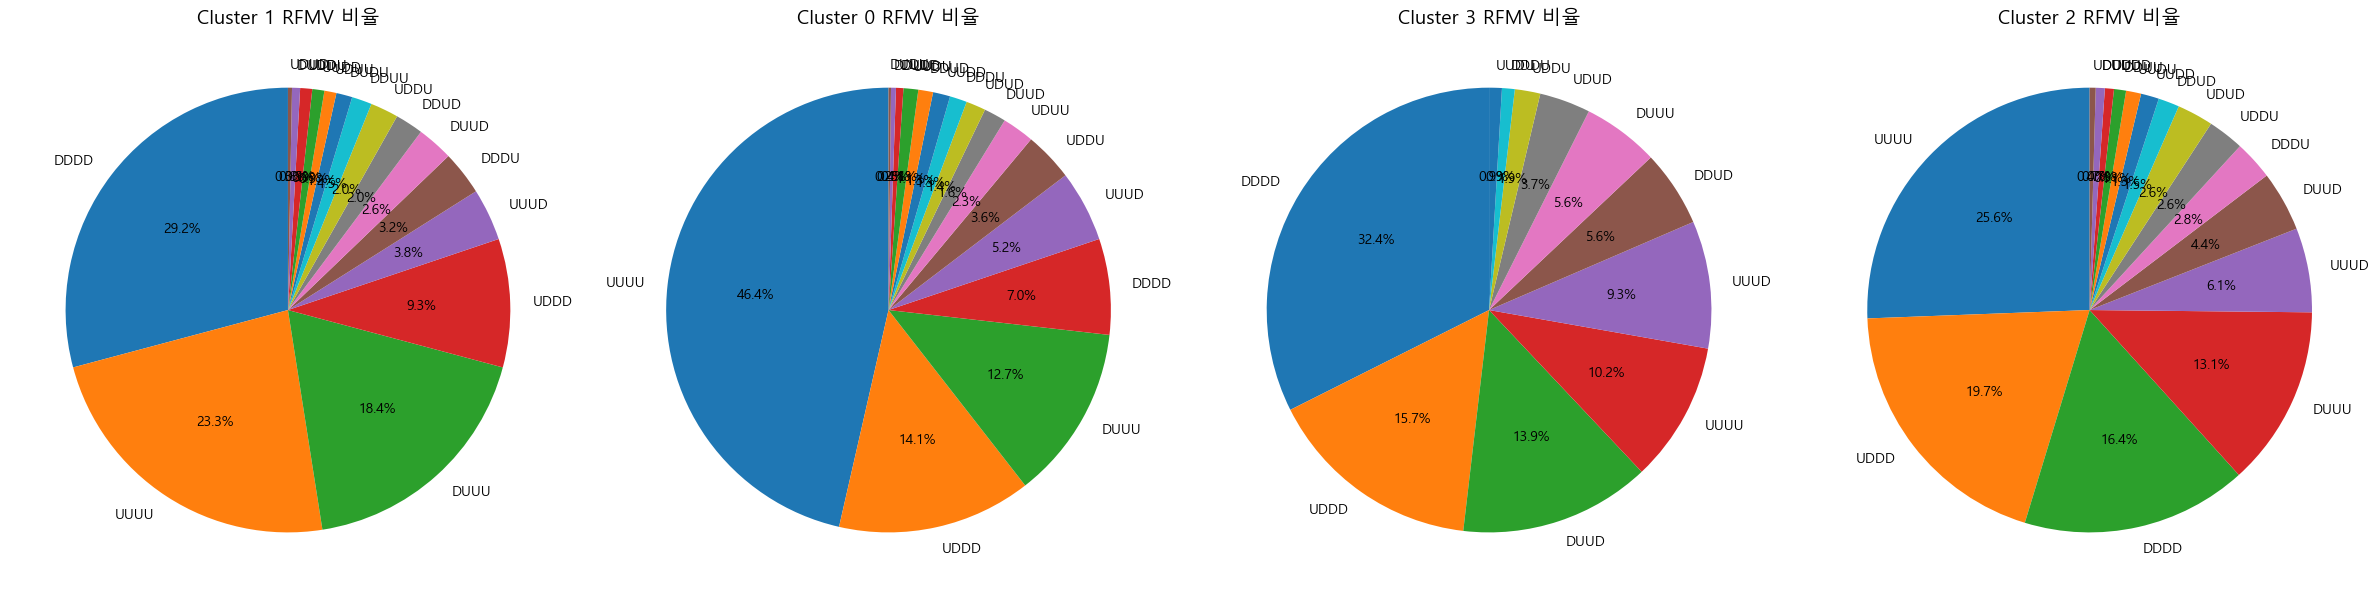

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 
plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False  

# 데이터 불러오기
file_path = r"C:\Users\Jimin\Desktop\project\ecommerce\전처리\updated_data_with_rfmv_score.csv"  # 입력 데이터 경로
data = pd.read_csv(file_path)

# 클러스터별 RFMV_Score 비율 계산
cluster_rfmv_distribution = data.groupby('Cluster')['RFMV_Score'].value_counts(normalize=True).rename('Percentage').reset_index()

# 시각화
clusters = data['Cluster'].unique()
num_clusters = len(clusters)

fig, axes = plt.subplots(1, num_clusters, figsize=(6 * num_clusters, 6))

for i, cluster in enumerate(clusters):
    # 각 클러스터 데이터 추출
    cluster_data = cluster_rfmv_distribution[cluster_rfmv_distribution['Cluster'] == cluster]
    
    # 원형 그래프 생성
    axes[i].pie(cluster_data['Percentage'], labels=cluster_data['RFMV_Score'], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'Cluster {cluster} RFMV 비율', fontsize=14)

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()
